# Google Data Analytics Capstone

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, time, datetime, timedelta
import os
import matplotlib.ticker as mtick
import warnings
from scipy.stats import linregress

In [2]:
# Read in data from the weightLogInfo and dailyActivity CSVs
# The March-April data are labeled with a "1", and the April-May data are labeled with a "2"

path1 = "Fitabase Data 3.12.16-4.11.16/"
path2 = "Fitabase Data 4.12.16-5.12.16/"

end = "_merged.csv"

weightLog1 = pd.read_csv(path1 + "weightLogInfo" + end).dropna(subset=["Id","Date","WeightKg","WeightPounds",
                                                                       "BMI","IsManualReport","LogId"])
weightLog2 = pd.read_csv(path2 + "weightLogInfo" + end).dropna(subset=["Id","Date","WeightKg","WeightPounds",
                                                                       "BMI","IsManualReport","LogId"])

dailyActivity1 = pd.read_csv(path1 + "dailyActivity" + end)
dailyActivity2 = pd.read_csv(path2 + "dailyActivity" + end)

To compare the weight and activity data, we will look at the percent change in weight for each user and the trendlines for calories burnt each day, minutes spent sedentary each day, total minutes spent active each day, and minutes spent active each day weighted by the type of activity. "Very active" minutes will be given a weight of 5, "fairly active" minutes will be given a weight of 1, and "lightly active" minutes will be given a weight of 0.2.

First, we merge the different datasets into one big dataset that we can more easily manipulate.

In [3]:
# Concatenate dataframes, giving us date, weight in pounds, and if the weight log was manual or not 
# for all users 
weightData = pd.concat([weightLog1.loc[:,['Id','Date','WeightPounds','IsManualReport']],
                        weightLog2.loc[:,['Id','Date','WeightPounds','IsManualReport']]],ignore_index=True)

# Transform the weight log date and time data to Python date objects. This will allow us to match 
# daily activity data and weight log data
weightData['Date'] = pd.to_datetime(weightData['Date'],format="%m/%d/%Y %I:%M:%S %p").dt.date



# Repeat dataframe concatenation for daily activity data
activityData = pd.concat([dailyActivity1.loc[:,['Id','ActivityDate','VeryActiveMinutes',
                                                   'FairlyActiveMinutes','LightlyActiveMinutes',
                                                   'SedentaryMinutes','Calories']],
                     dailyActivity2.loc[:,['Id','ActivityDate','VeryActiveMinutes',
                                                   'FairlyActiveMinutes','LightlyActiveMinutes',
                                                   'SedentaryMinutes','Calories']]],ignore_index=True) 


# Add columns for weighted activity minutes and total activity minutes, as defined above
activityData.insert(len(activityData.columns),'TotalActiveMinutes',activityData['LightlyActiveMinutes']
                    + activityData['FairlyActiveMinutes'] + activityData['VeryActiveMinutes'])
activityData.insert(len(activityData.columns),'WeightedActiveMinutes',
                    0.2*activityData['LightlyActiveMinutes'] + 1*activityData['FairlyActiveMinutes'] + 
                    5*activityData['VeryActiveMinutes'])

# As above, transform the actvity date data to Python date objects
activityData['ActivityDate'] = pd.to_datetime(activityData['ActivityDate'],format="%m/%d/%Y").dt.date

# Rename the column "ActivityDate" to "Date" for ease of merging
activityData = activityData.rename(columns={'ActivityDate':'Date'})

# Merge dataframes into single dataframe. From the activity data, only keep ID and date (for ease of merging),
# and calories burnt, minutes spent sedentary, total minutes spent active, and weighted minutes spent active, 
# because these are the data we will be comparing
# During this, drop any users who don't have weight log data
fullData = activityData[['Id','Date','Calories','SedentaryMinutes','TotalActiveMinutes',
                         'WeightedActiveMinutes']].merge(weightData,how='left').sort_values('Date',
                          ignore_index=True).dropna(subset=['WeightPounds'])

# Transform ID into string for ease of plotting
fullData['Id'] = fullData['Id'].astype('str')

In [4]:
# Find number of unique user IDs in the weight log data

ids = pd.unique(fullData["Id"])

print(f"There are {len(ids)} unique user IDs in the weight log data.")

There are 13 unique user IDs in the weight log data.


Fitbit users can log their weight by inputting it manually, or by using the Fitbit Aria line of smart scales, which syncs the device. Users who log their weight manually are denoted in green, and users who log their weight using a smart scale are denoted in magenta.

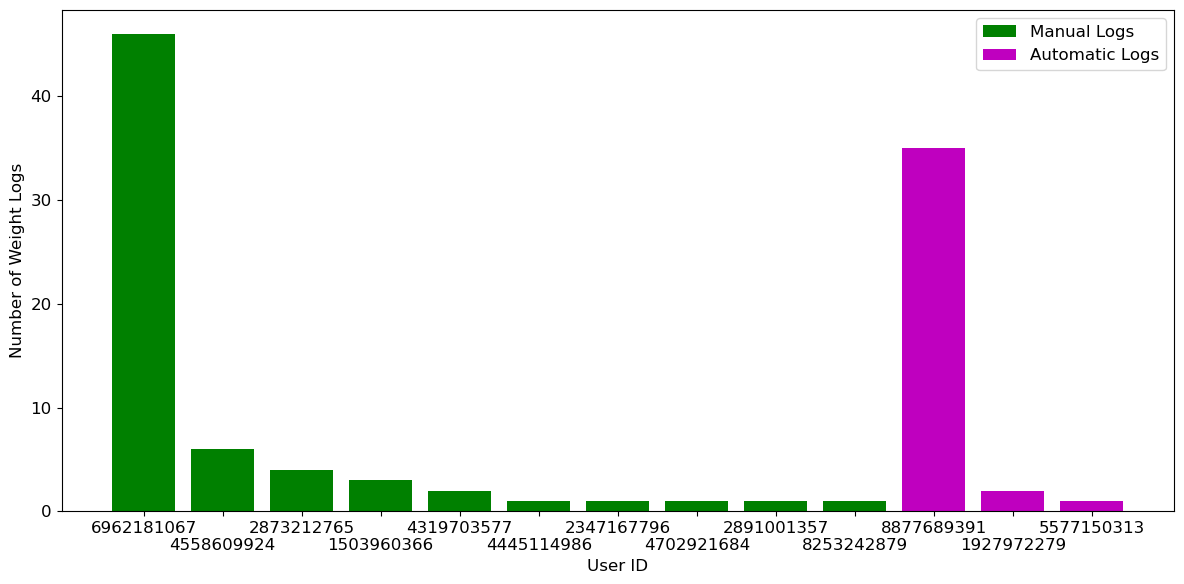

In [5]:
# Sort number of times weight is logged per user ID

w_manual = fullData["IsManualReport"] == True

LogCounts_manual = fullData["Id"][w_manual].value_counts().to_dict()
LogCounts_auto = fullData["Id"][~w_manual].value_counts().to_dict()

# Make a histogram based on the dict
plt.rcParams['figure.figsize'] = 12,6
plt.rcParams['font.size'] = 12

warnings.filterwarnings("ignore")

fig, ax = plt.subplots()
ax.bar(*zip(*LogCounts_manual.items()),color='g',label="Manual")
ax.bar(*zip(*LogCounts_auto.items()),color='m',label="Automatic")
ax.set_xlabel("User ID")
ax.set_ylabel("Number of Weight Logs")
ax.legend()
ax.set_xticklabels(["\n"*(i%2) + l for i,l in enumerate(list(LogCounts_manual.keys()) + 
                                                        list(LogCounts_auto.keys()))])
plt.tight_layout()
plt.savefig("images/log_counts.png")
plt.show()

Two users- IDs 6962181067 and 8877689391- log their weights much more frequently than the other 11 users. These are the "frequent users". The other group of users are the "average users". We will compare how the weight and activity data differ between the two groups during this 2-month period.

In [6]:
# Separate into "frequent users" who log their weights frequently and "average users" who log less often

LogCounts_total = fullData["Id"].value_counts().to_dict()

freq_users = np.array([k for k in LogCounts_total if LogCounts_total[k] > 30])
avg_users = np.setdiff1d(np.array(list(LogCounts_total)),freq_users)
all_users = np.array(list(LogCounts_total))

Then, we set up different Python methods needed for vizualizing the data.

In [7]:
def get_percent_change(series):
    # Get the percent change from the beginning to end of a pandas Series. Data must be in
    # chronological order
    
    return 100*(series.iloc[-1] - series.iloc[0])/series.iloc[0]

In [17]:
def get_trendline(x,y):
    # Get the linear trendline given x and y data
    # linregress calculates a linear least-squares regression from two sets of x and y data
    result = linregress(x,y)
    
    return result.slope, result.intercept

In [9]:
def file_setup(fname,topline):
    # Set up a csv file to store data
    
    if os.path.exists(fname):
        os.remove(fname)
    f = open(fname, "w")
    f.write(topline)
    f.close()

In [10]:
def file_append(fname,content):
    # Set up an "append file" function to more easily append files
    
    f = open(fname, "a")
    f.write(f"{content}\n")
    f.close()

In [11]:
def make_line_plot(title,date,y,ylabel):
    # Set up a method to easily make a line plot for a single set of x and y data
    # This function assumes that the x data is made up of Python datetime objects
        
    plt.rcParams['figure.figsize'] = 12,8
    plt.rcParams['font.size'] = 12
        
    plt.title(title)
    plt.plot(date,y,'k-')
    
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.xticks([datetime(year=2016, month=3, day=4),datetime(year=2016, month=3, day=11),
               datetime(year=2016, month=3, day=18),datetime(year=2016, month=3, day=25),
               datetime(year=2016, month=4, day=1),datetime(year=2016, month=4, day=8),
               datetime(year=2016, month=4, day=15),datetime(year=2016, month=4, day=22),
               datetime(year=2016, month=4, day=29),datetime(year=2016, month=5, day=6)])    
    plt.xlim(date.iloc[0],date.iloc[-1])
    plt.tight_layout()

In [12]:
def make_line_subplots(suptitle,subtitles,date,ys,ylabels,trendlines,user_id):
    # Set up a function to easily make a plot of four subplots for four sets of y data and a single set of 
    # x data
    # This function assumes that the x data is made up of Python datetime objects
    # This function also takes a trendline
        
    if len(subtitles) != 4 | len(ys) != 4 | len(trendlines) != 4 | len(ylabels) != 4:
        return "Error! 2x2 plot cannot be generated from this data."
    else:
        bool_style = 'b-' if user_id in avg_users else 'r-'
            
        plt.rcParams['font.size'] = 12
        plt.rcParams['figure.figsize'] = 16,16

        fig, ax = plt.subplots(2, 2,sharex=True)
        
        ax[0,0].set_title(subtitles[0])
        ax[0,0].plot(date,ys[0],'k-')
        ax[0,0].plot(date,trendlines[0],bool_style)
        ax[0,0].set_ylabel(ylabels[0])
        
        ax[0,1].set_title(subtitles[1])
        ax[0,1].plot(date,ys[1],'k-')
        ax[0,1].plot(date,trendlines[1],bool_style)
        ax[0,1].set_ylabel(ylabels[1])

        ax[1,0].set_title(subtitles[2])
        ax[1,0].plot(date,ys[2],'k-')
        ax[1,0].plot(date,trendlines[2],bool_style)
        ax[1,0].set_ylabel(ylabels[2])

        ax[1,1].set_title(subtitles[3])
        ax[1,1].plot(date,ys[3],'k-')
        ax[1,1].plot(date,trendlines[3],bool_style)
        ax[1,1].set_ylabel(ylabels[3])

        plt.suptitle(suptitle,fontsize=14)
        plt.xlabel("Date")
        plt.xticks([datetime(year=2016, month=3, day=4),datetime(year=2016, month=3, day=11),
                   datetime(year=2016, month=3, day=18),datetime(year=2016, month=3, day=25),
                   datetime(year=2016, month=4, day=1),datetime(year=2016, month=4, day=8),
                   datetime(year=2016, month=4, day=15),datetime(year=2016, month=4, day=22),
                   datetime(year=2016, month=4, day=29),datetime(year=2016, month=5, day=6)])    
        plt.xlim(date.iloc[0],date.iloc[-1])
        fig.tight_layout()

In [13]:
def make_bar_from_csv(fname,title):
    data = pd.read_csv(fname,dtype={"ID":str}).sort_values("Percent change")

    plt.rcParams['font.size'] = 14
    plt.rcParams['figure.figsize'] = 12,8
    
    bool_colors = np.where(np.array([i in avg_users for i in data["ID"]]) == True,'b','r')
    fig, ax = plt.subplots()
    plt.title(title)
    ax.bar(data["ID"],data["Percent change"],color=bool_colors)
    ax.set_xticklabels(["\n"*(i%2) + l for i,l in enumerate(data["ID"])])
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.xlabel("User ID")
    plt.ylabel("Percent change")
    plt.axhline(0,c='k',ls='--')

In [14]:
def plot_data(id_list,data):
    # This function generates all the plots we want from the weight and activity data
    # with the exception of the percent change graphs
        
    # Set up dictionary to store trendline data over the loop
    trendlines = {'calorie':{'m':[],'b':[]},'sedentary':{'m':[],'b':[]},'total_activity':{'m':[],'b':[]},
                 'weighted_activity':{'m':[],'b':[]}}
        
    # Select the indices where the given ID matches the user ID in the data
    for i in id_list:
        w_userid = data['Id'] == i
        userData = data[w_userid]

        # Append the file if there is more than one non-NaN data point- percent change doesn't make sense as a
        # metric if there is only one data point
        if len(userData['WeightPounds'].dropna()) > 1:
            file_append("generated_csvs/weight_change.csv",f"{i}," + 
                        f"{get_percent_change(userData['WeightPounds'].dropna())}")
            
            # Make a line plot of the weight over time
            make_line_plot(f"Weight over Time for ID {i}",userData.dropna(subset='WeightPounds')['Date'],
                           userData['WeightPounds'].dropna(),"Weight (Lbs)")
            plt.savefig(f"images/{i}_weight.png")
            plt.show()
            
        # Plot trendlines if there is more than one non-NaN data point- trendlines don't make sense
        # if there is only one data point
        if ((len(userData['Calories'].dropna()) > 1) and (len(userData['SedentaryMinutes'].dropna()) > 1) 
            and (len(userData['TotalActiveMinutes'].dropna()) > 1) and 
            len(userData['WeightedActiveMinutes'].dropna()) > 1):
            # Drop data points where calories burnt is small- this is an implausible measurement, so we assume
            # the activity data associated with these measurements are in some way flawed
            w_zero_cal = userData['Calories'] < 100
            userData = userData.drop(userData[w_zero_cal].index)

            # Create plot of 2x2 subplots daily calories burnt, daily minutes spent sedentary, daily minutes
            # spent in any activity, and daily minutes spent active weighted by activity category

            dateSeconds = np.array([(datetime(*i.timetuple()[:6]) - datetime(1970, 1, 1)) / timedelta(seconds=1) 
                        for i in userData['Date']]).astype('float')

            # Get trendlines for each object, and store in dict for later use; also store trendline in a list
            # for plotting
            trendlines_list = []

            m,b = get_trendline(dateSeconds,userData['Calories'])
            trendlines['calorie']['m'].append(m)
            trendlines['calorie']['b'].append(b)
            trendlines_list.append(m*dateSeconds+b)

            m,b = get_trendline(dateSeconds,userData['SedentaryMinutes'])
            trendlines['sedentary']['m'].append(m)
            trendlines['sedentary']['b'].append(b)
            trendlines_list.append(m*dateSeconds+b)

            m,b = get_trendline(dateSeconds,userData['TotalActiveMinutes'])
            trendlines['total_activity']['m'].append(m)
            trendlines['total_activity']['b'].append(b)
            trendlines_list.append(m*dateSeconds+b)

            m,b = get_trendline(dateSeconds,userData['WeightedActiveMinutes'])
            trendlines['weighted_activity']['m'].append(m)
            trendlines['weighted_activity']['b'].append(b)
            trendlines_list.append(m*dateSeconds+b)

            # Send everything to subplot method
            make_line_subplots(f"Activity Data for ID {i}",
                               ["Daily Calories Burnt","Daily Sedentary Minutes",
                                                            "Daily Total Active Minutes",
                                                            "Daily Weighted Active Minutes"],
                               userData['Date'],
                               [userData['Calories'],userData['SedentaryMinutes'],userData['TotalActiveMinutes'],
                                userData['WeightedActiveMinutes']],
                               ["Calories Burnt","Minutes Spent Sedentary",
                                                "Minutes Spent Active (Total)","Minutes Spent Active (Weighted)"],
                               trendlines_list,i)
            plt.savefig(f"images/{i}_activity.png")
            plt.show()

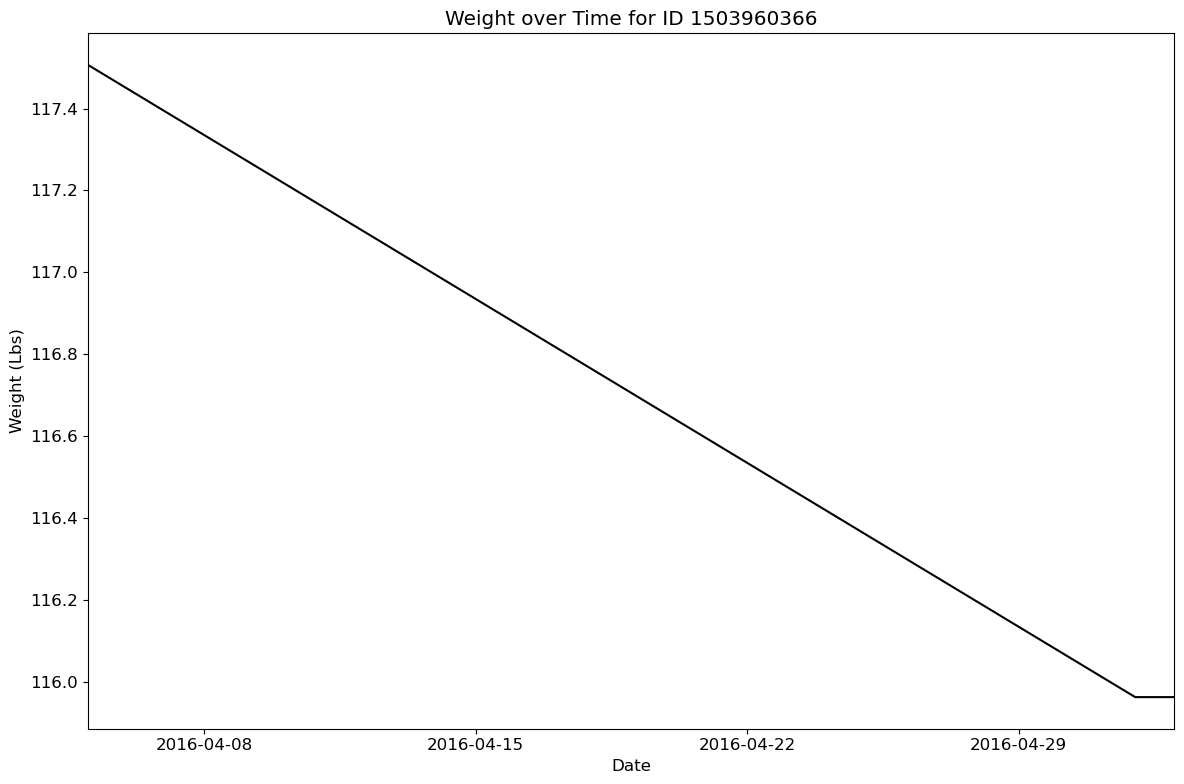

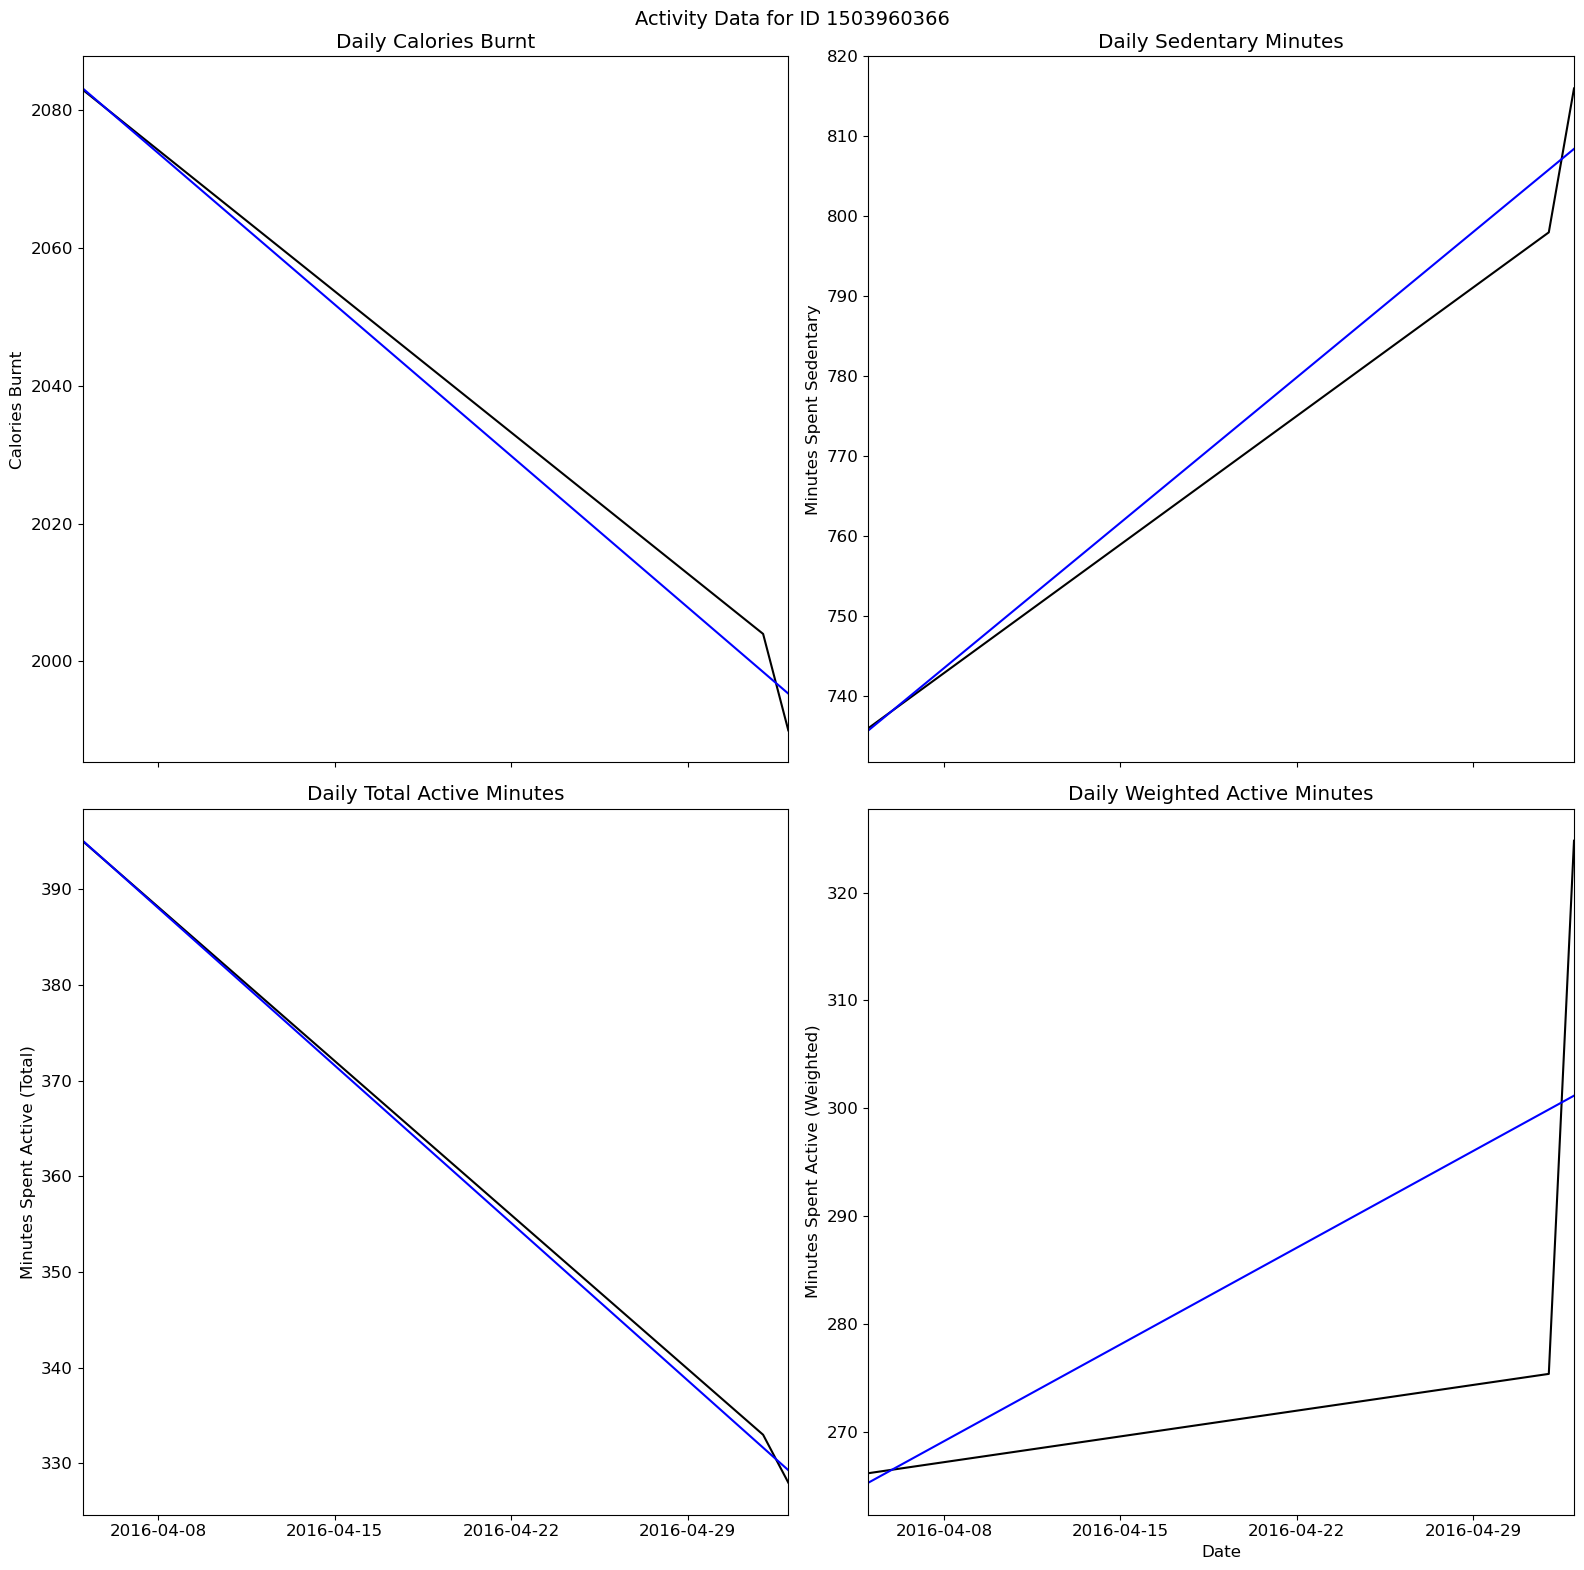

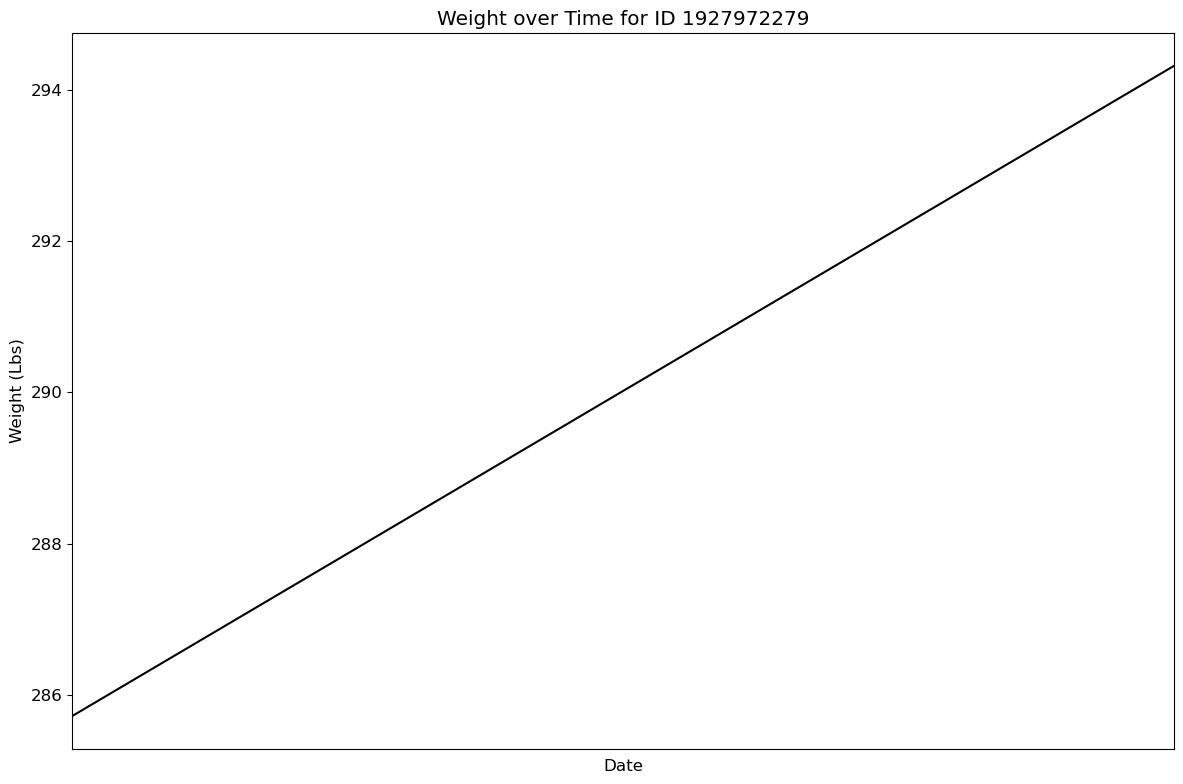

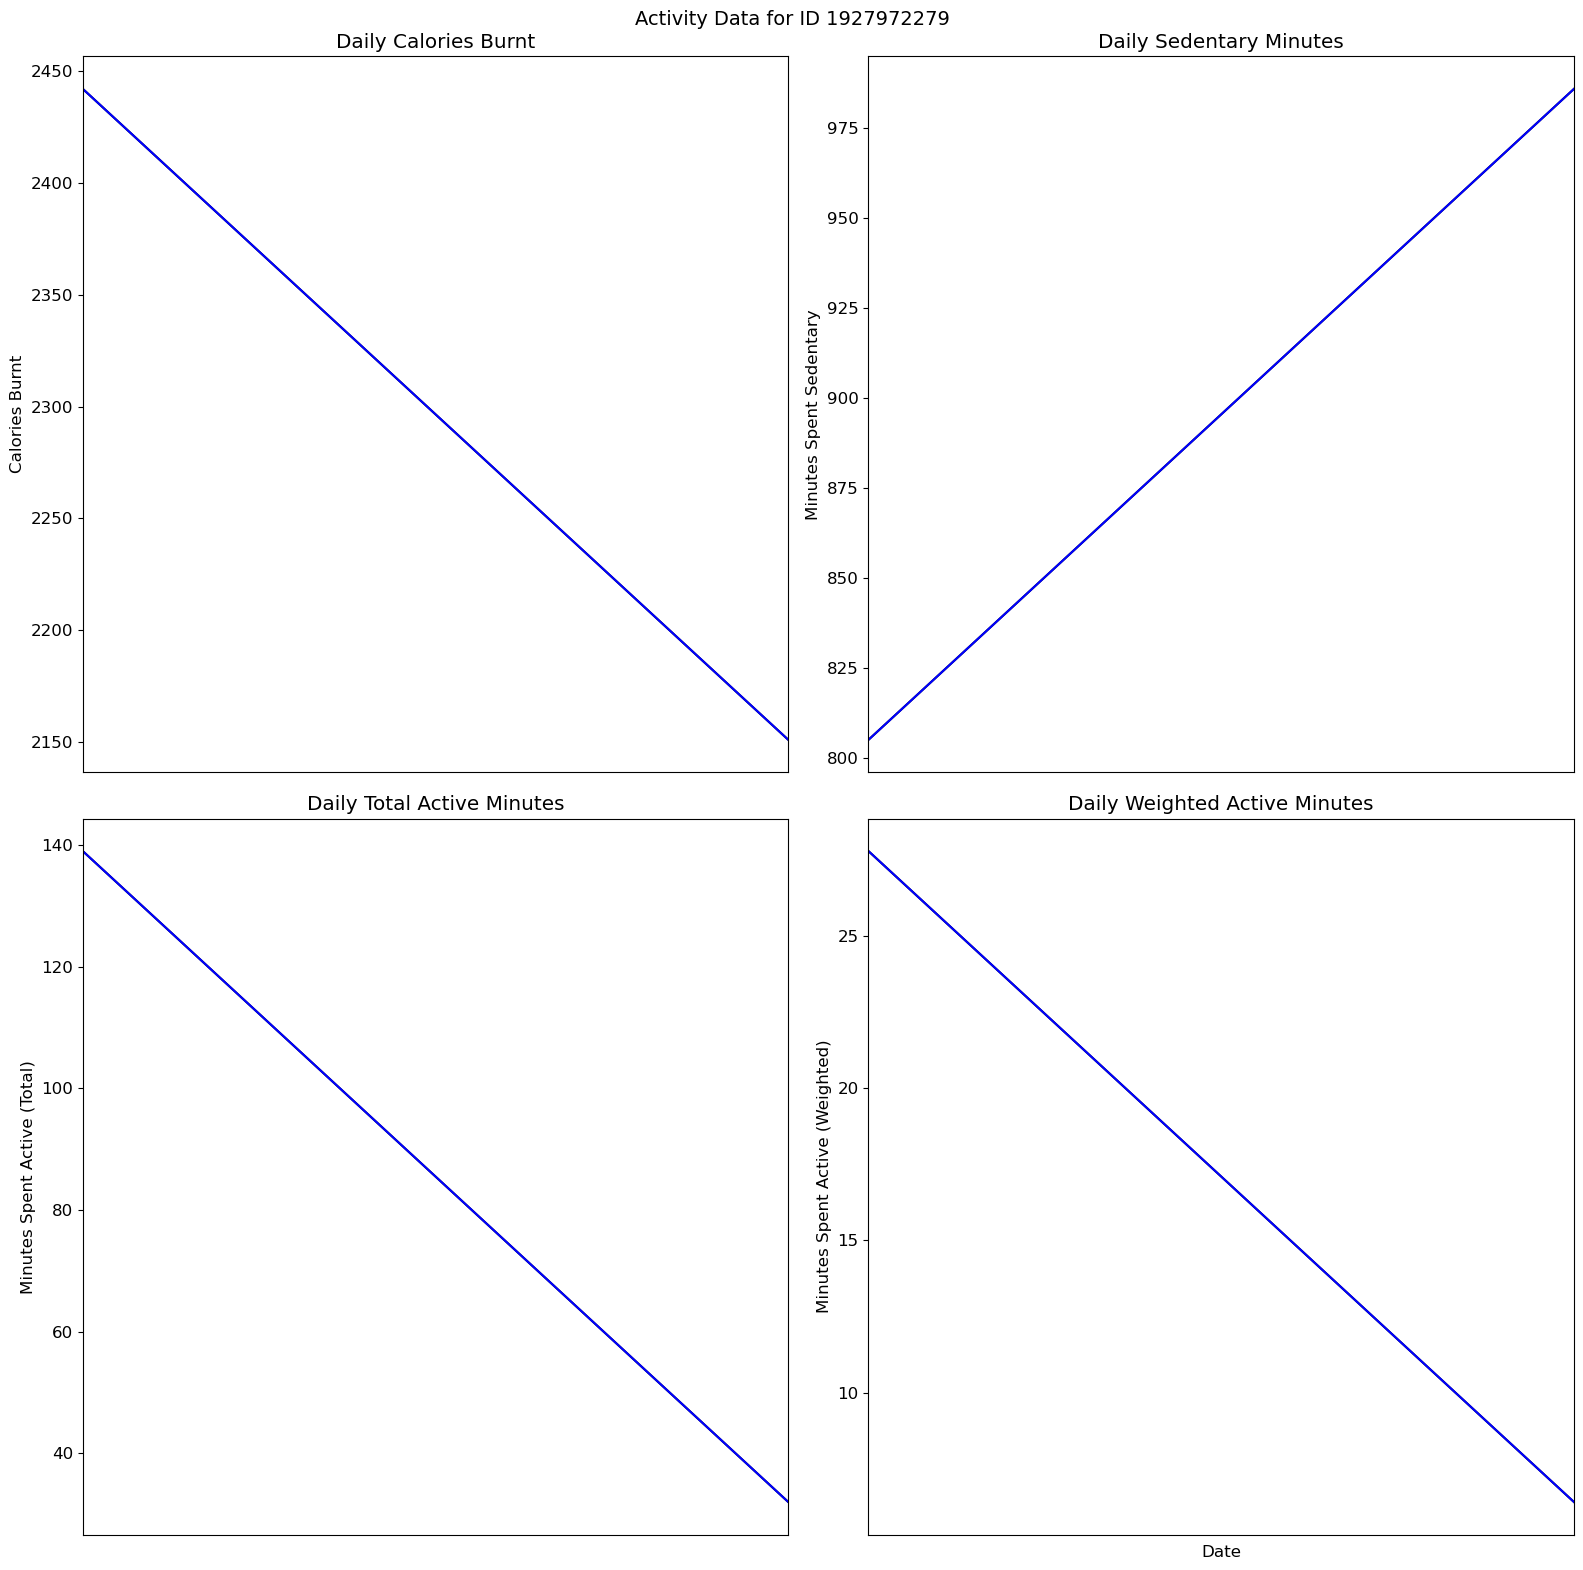

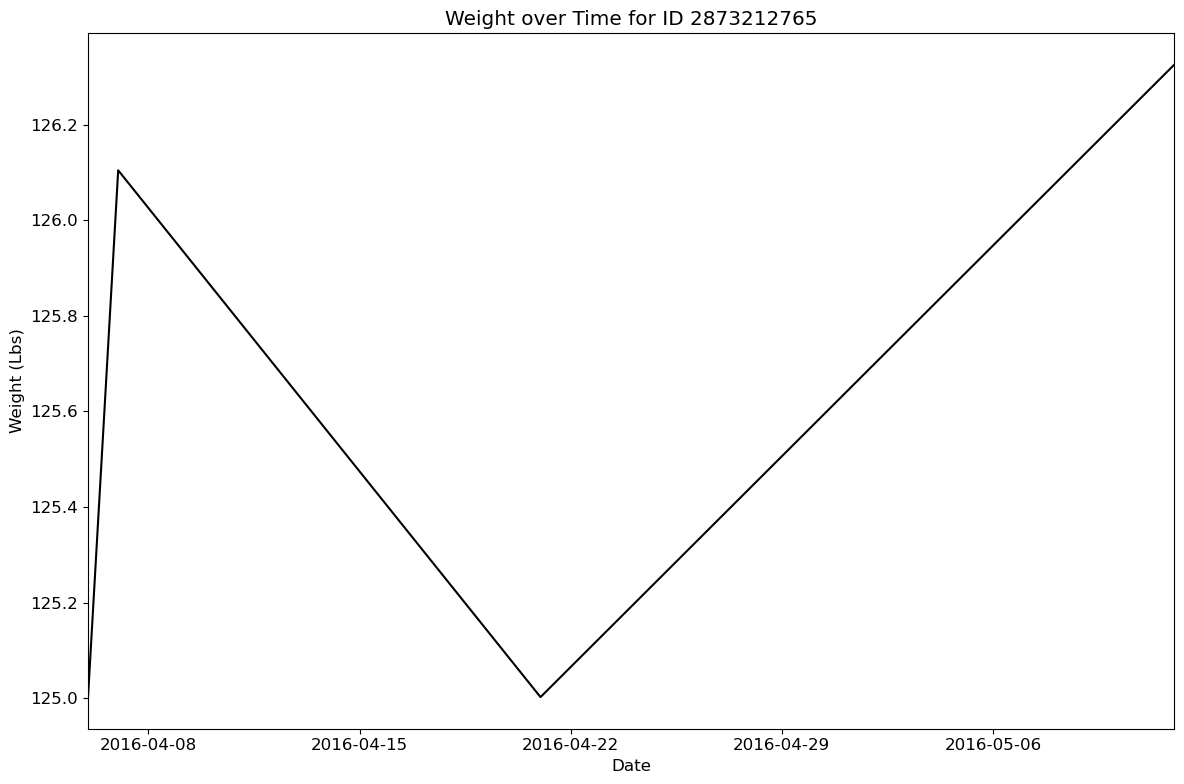

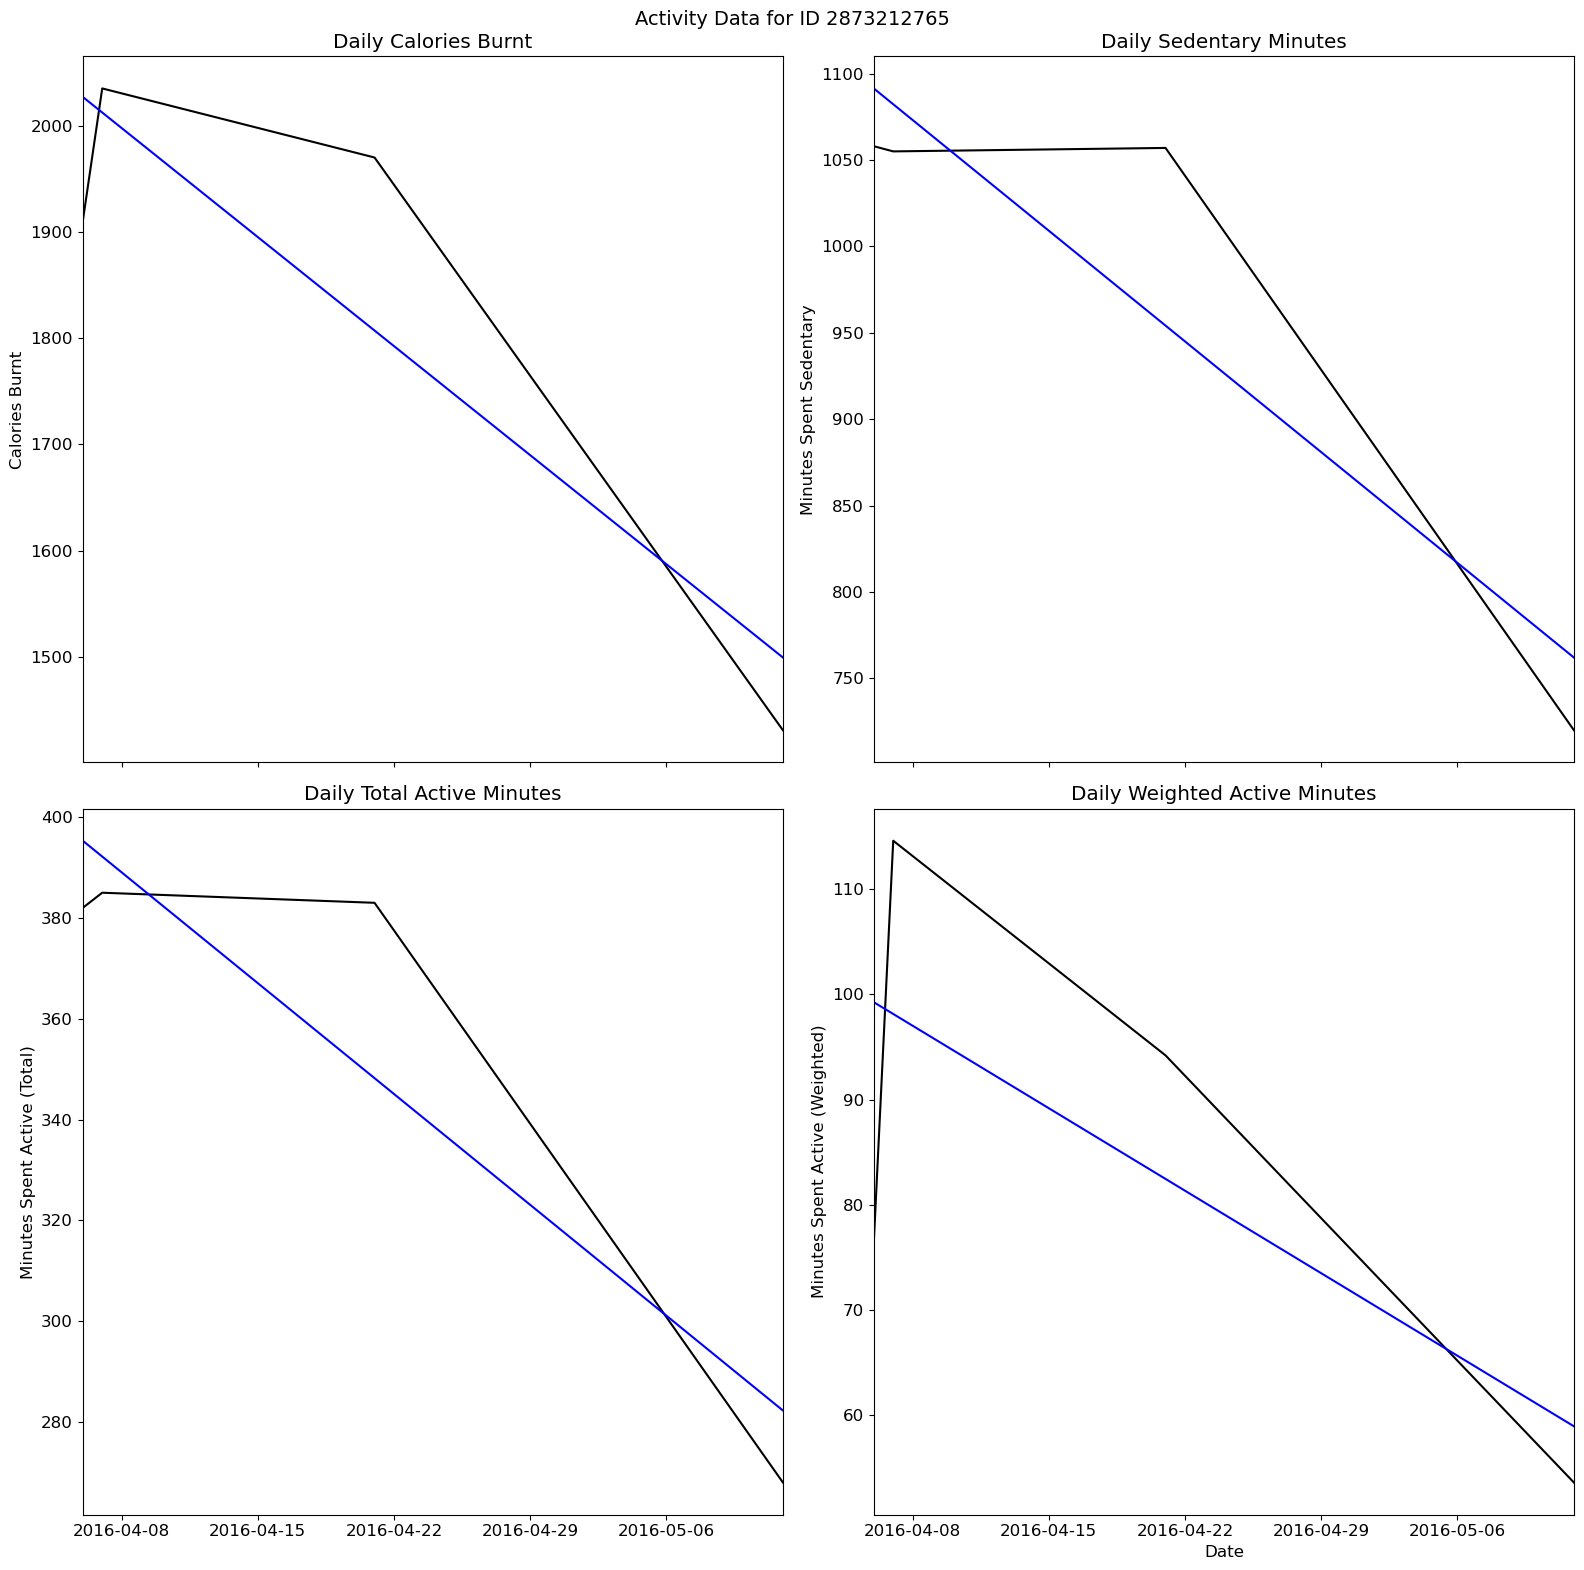

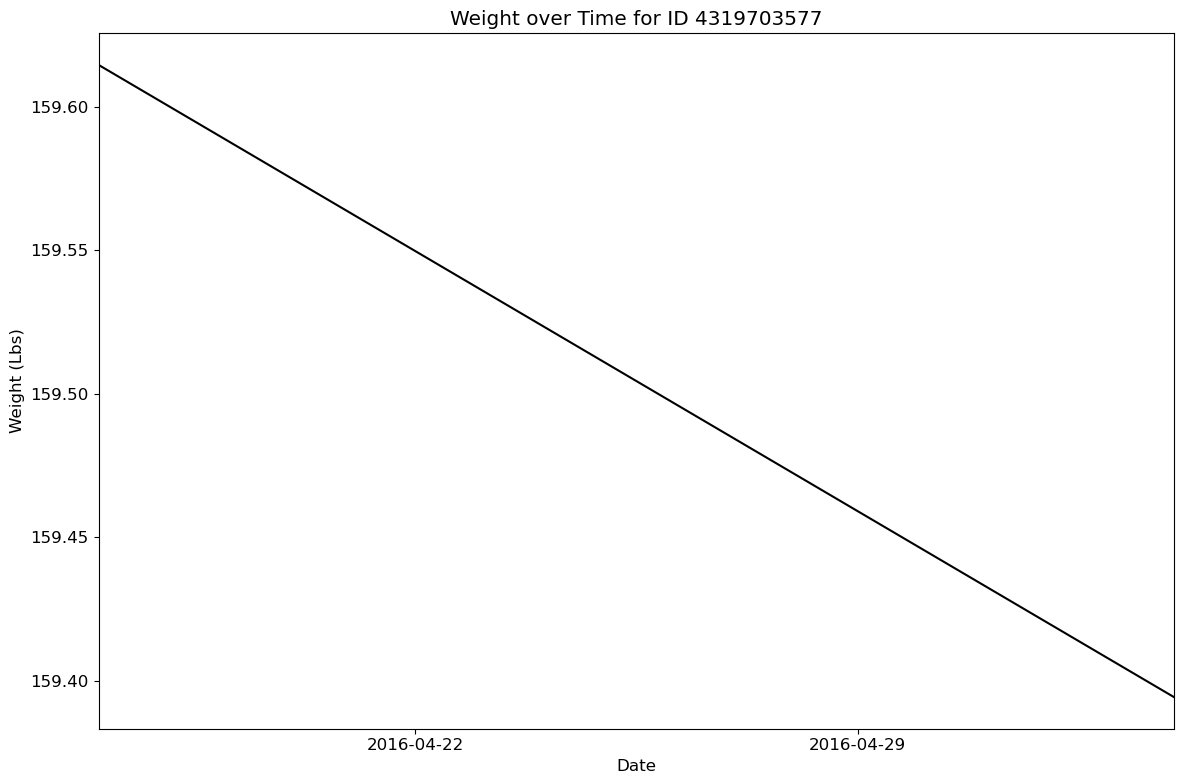

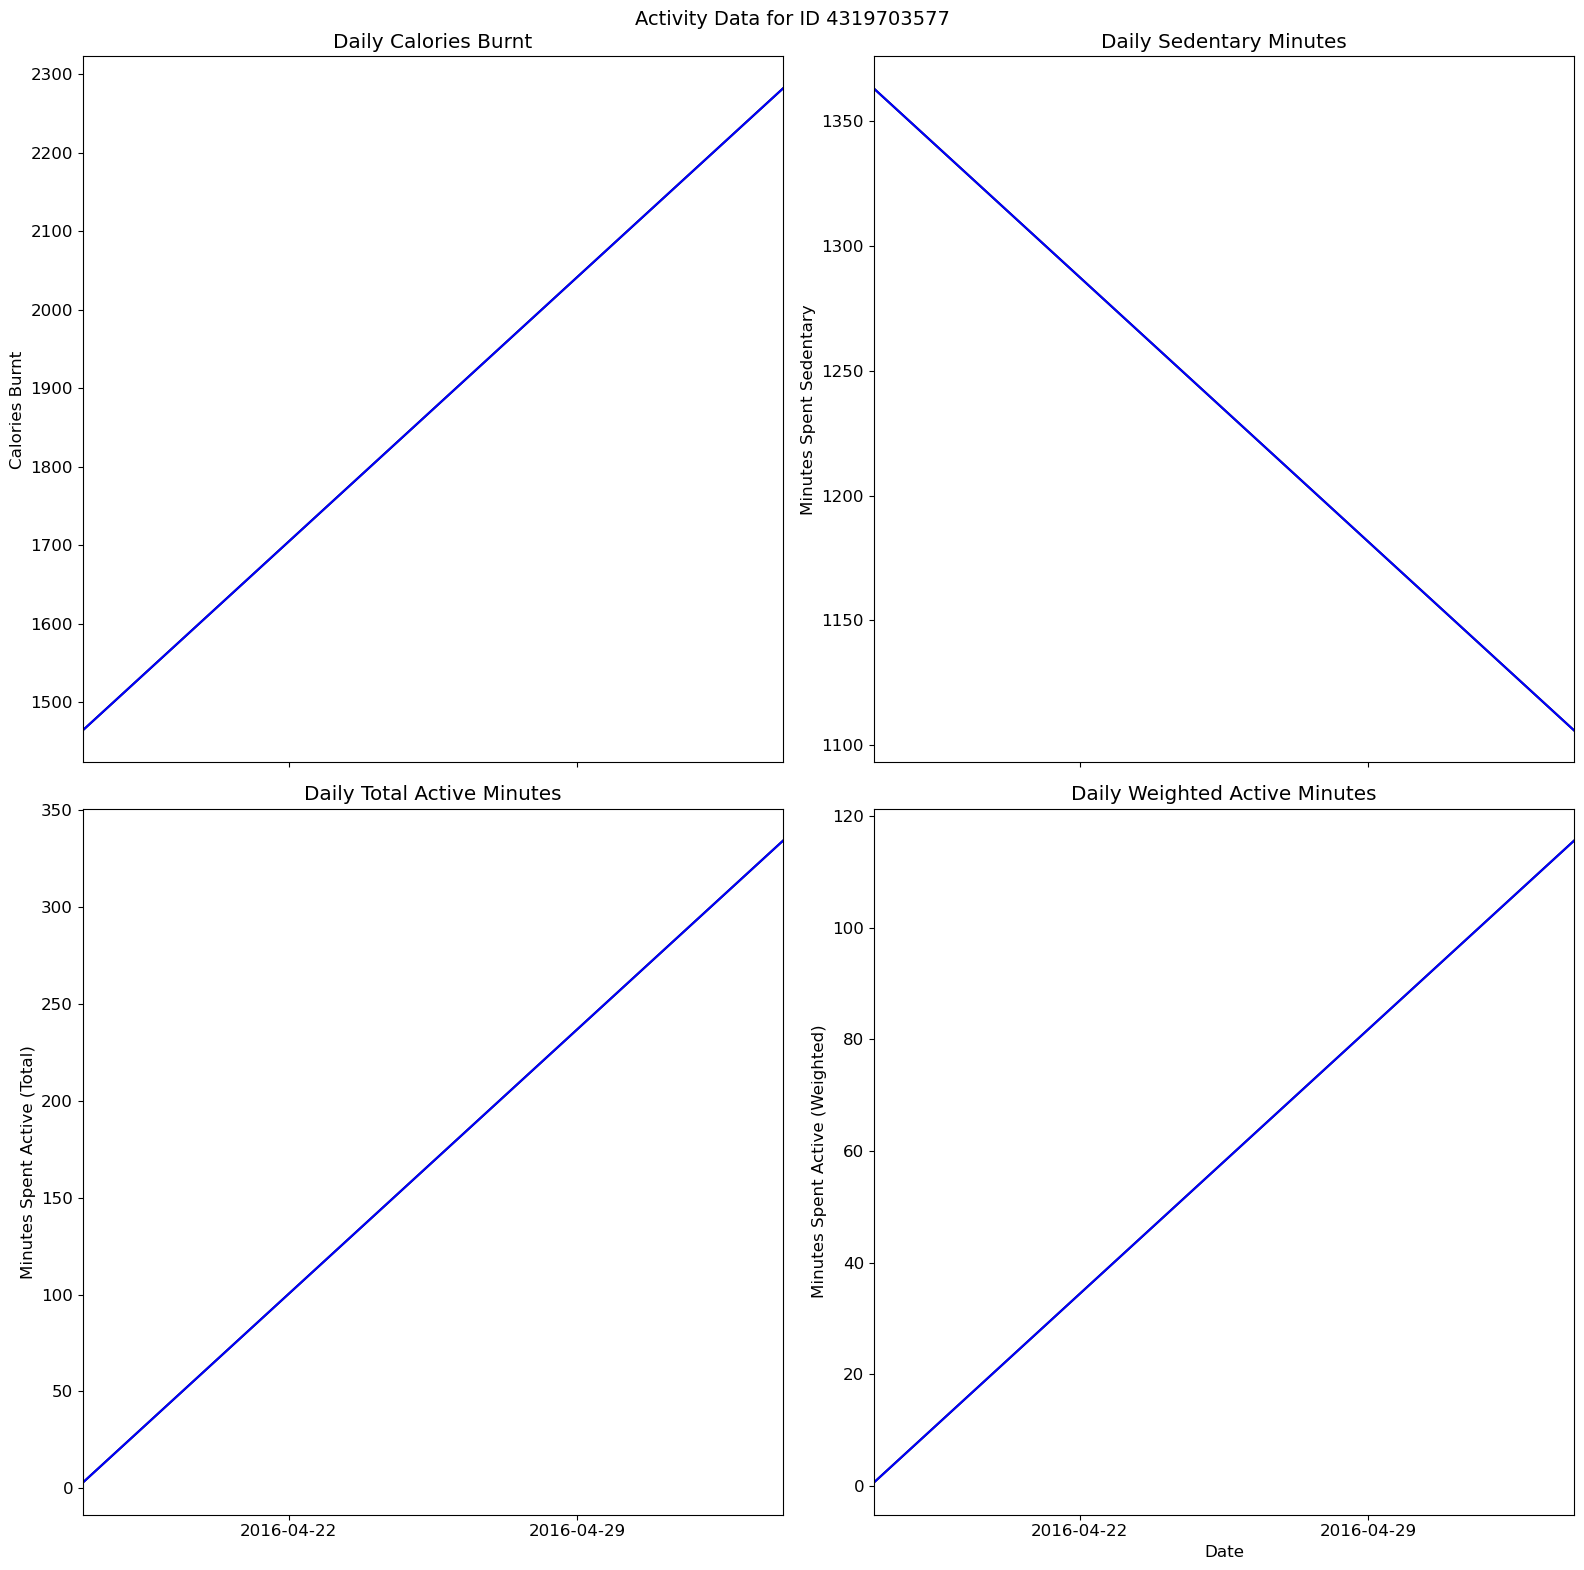

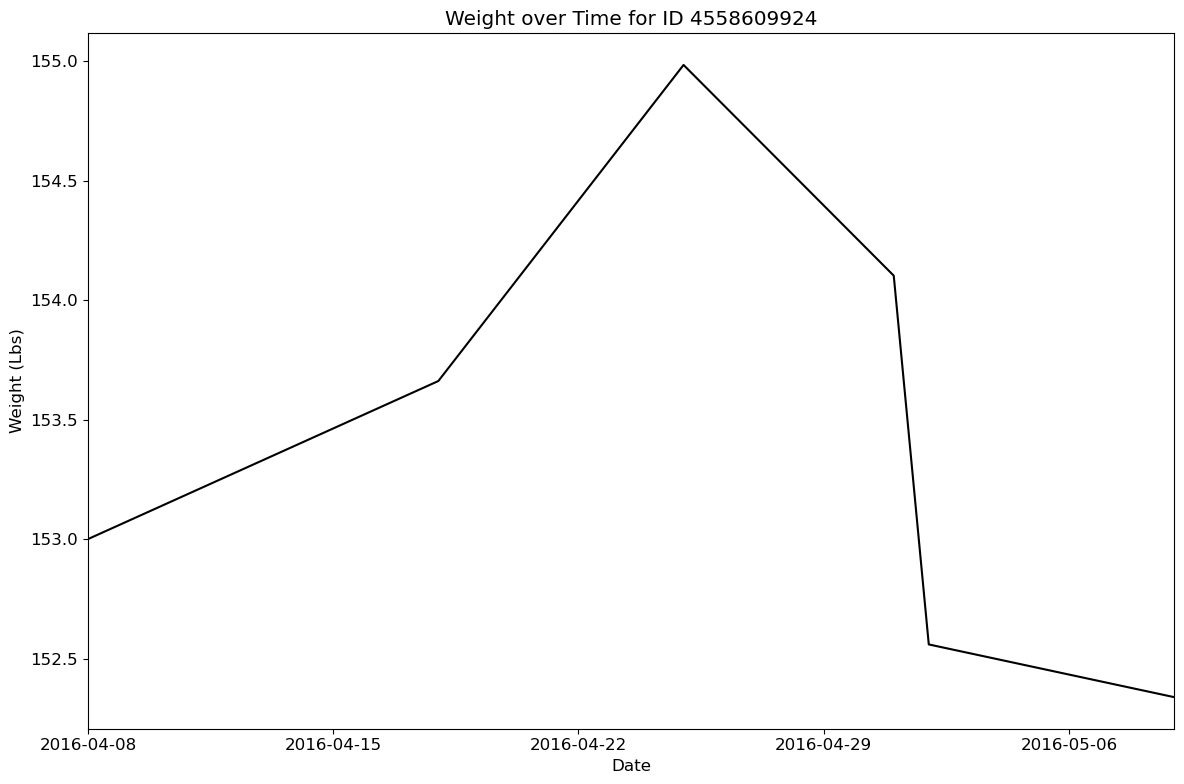

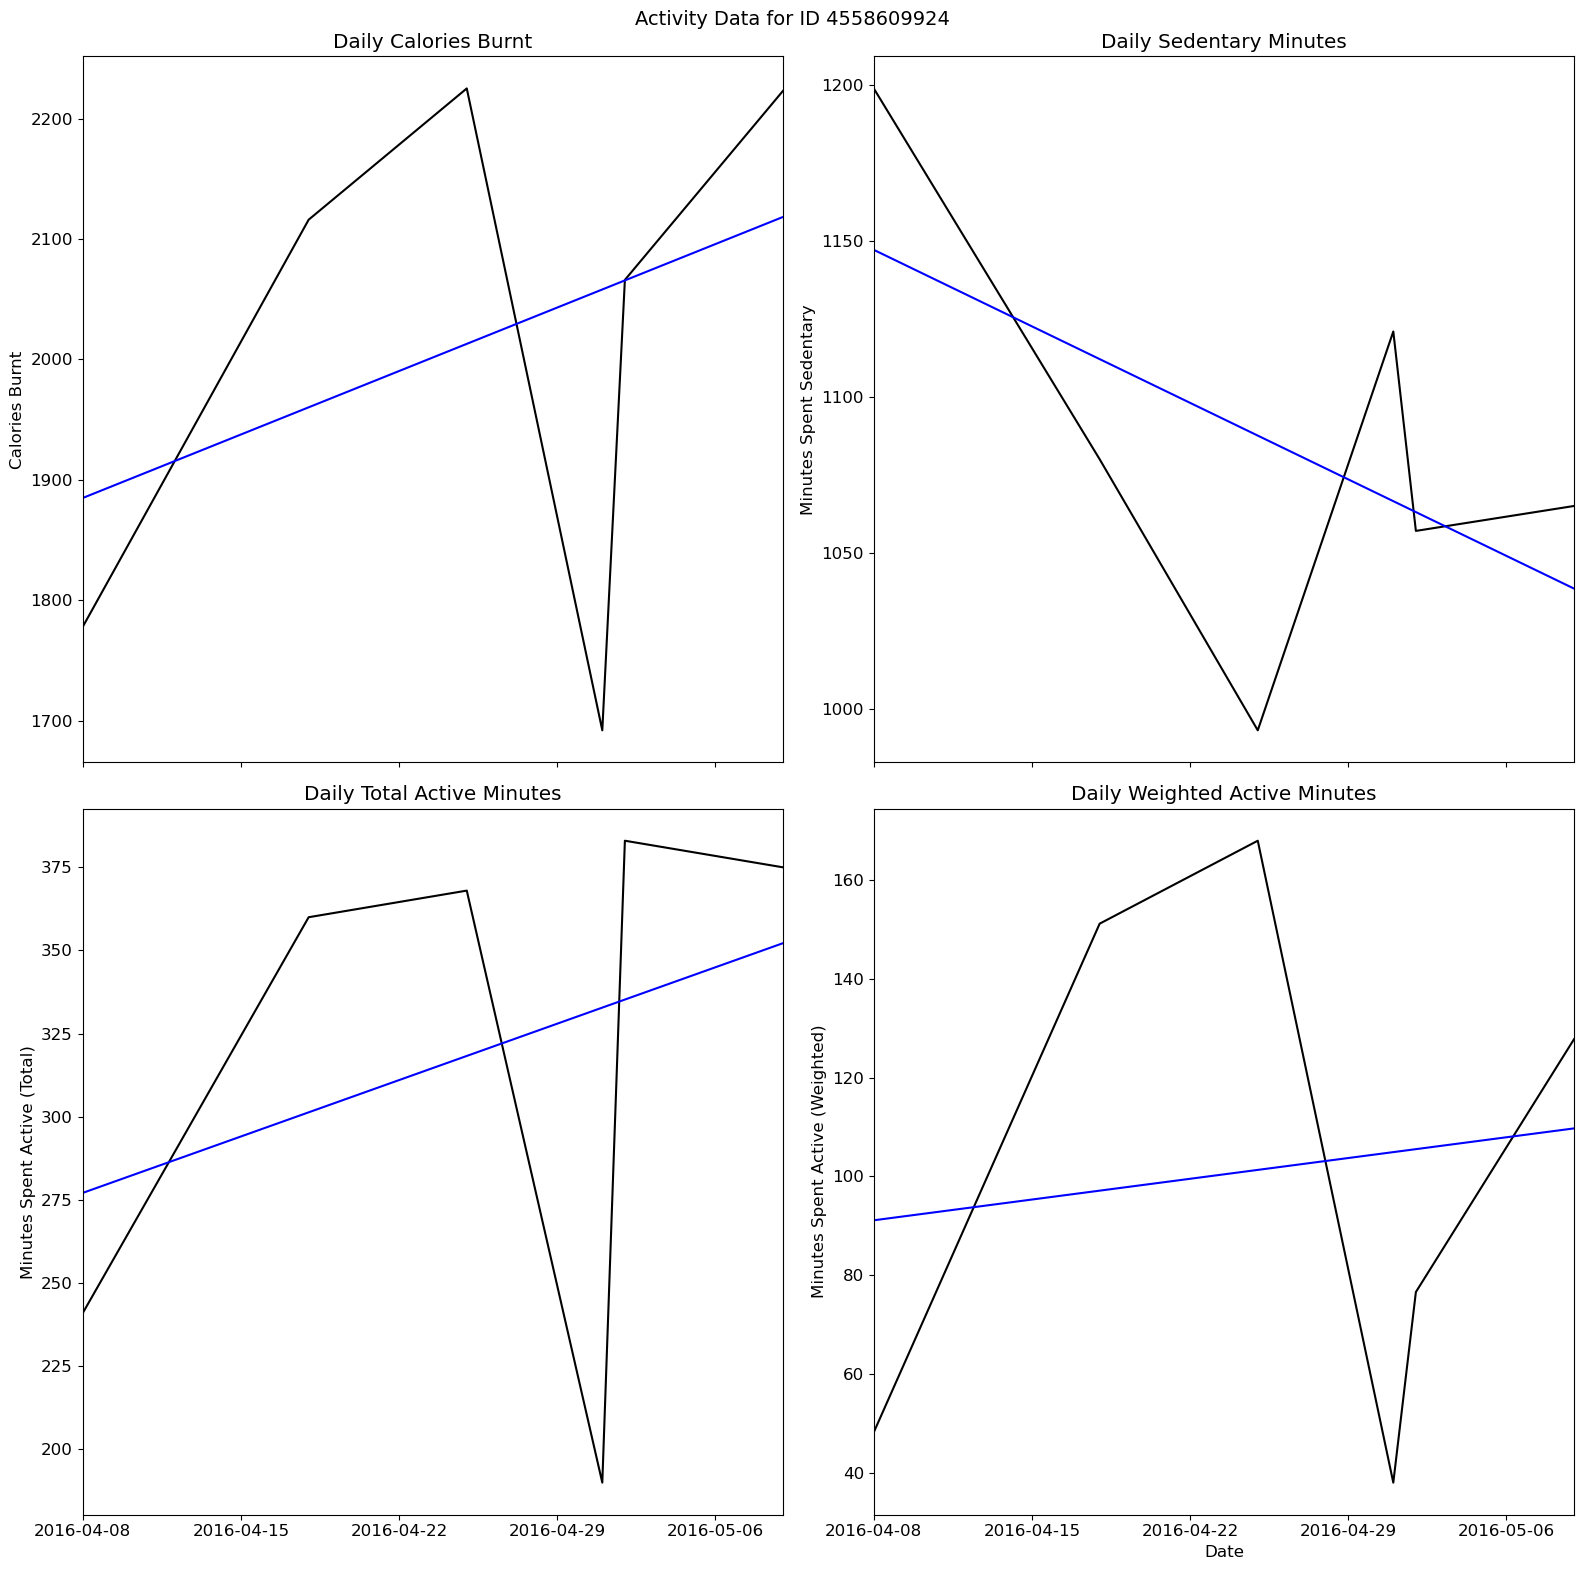

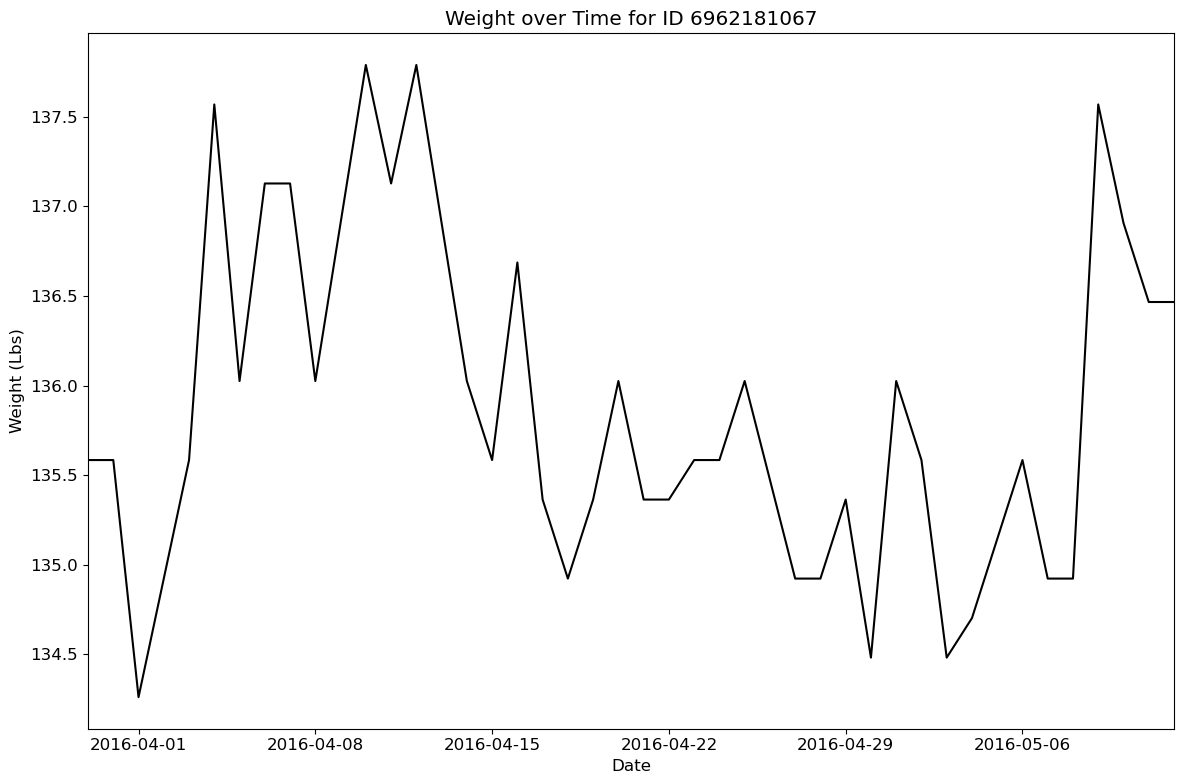

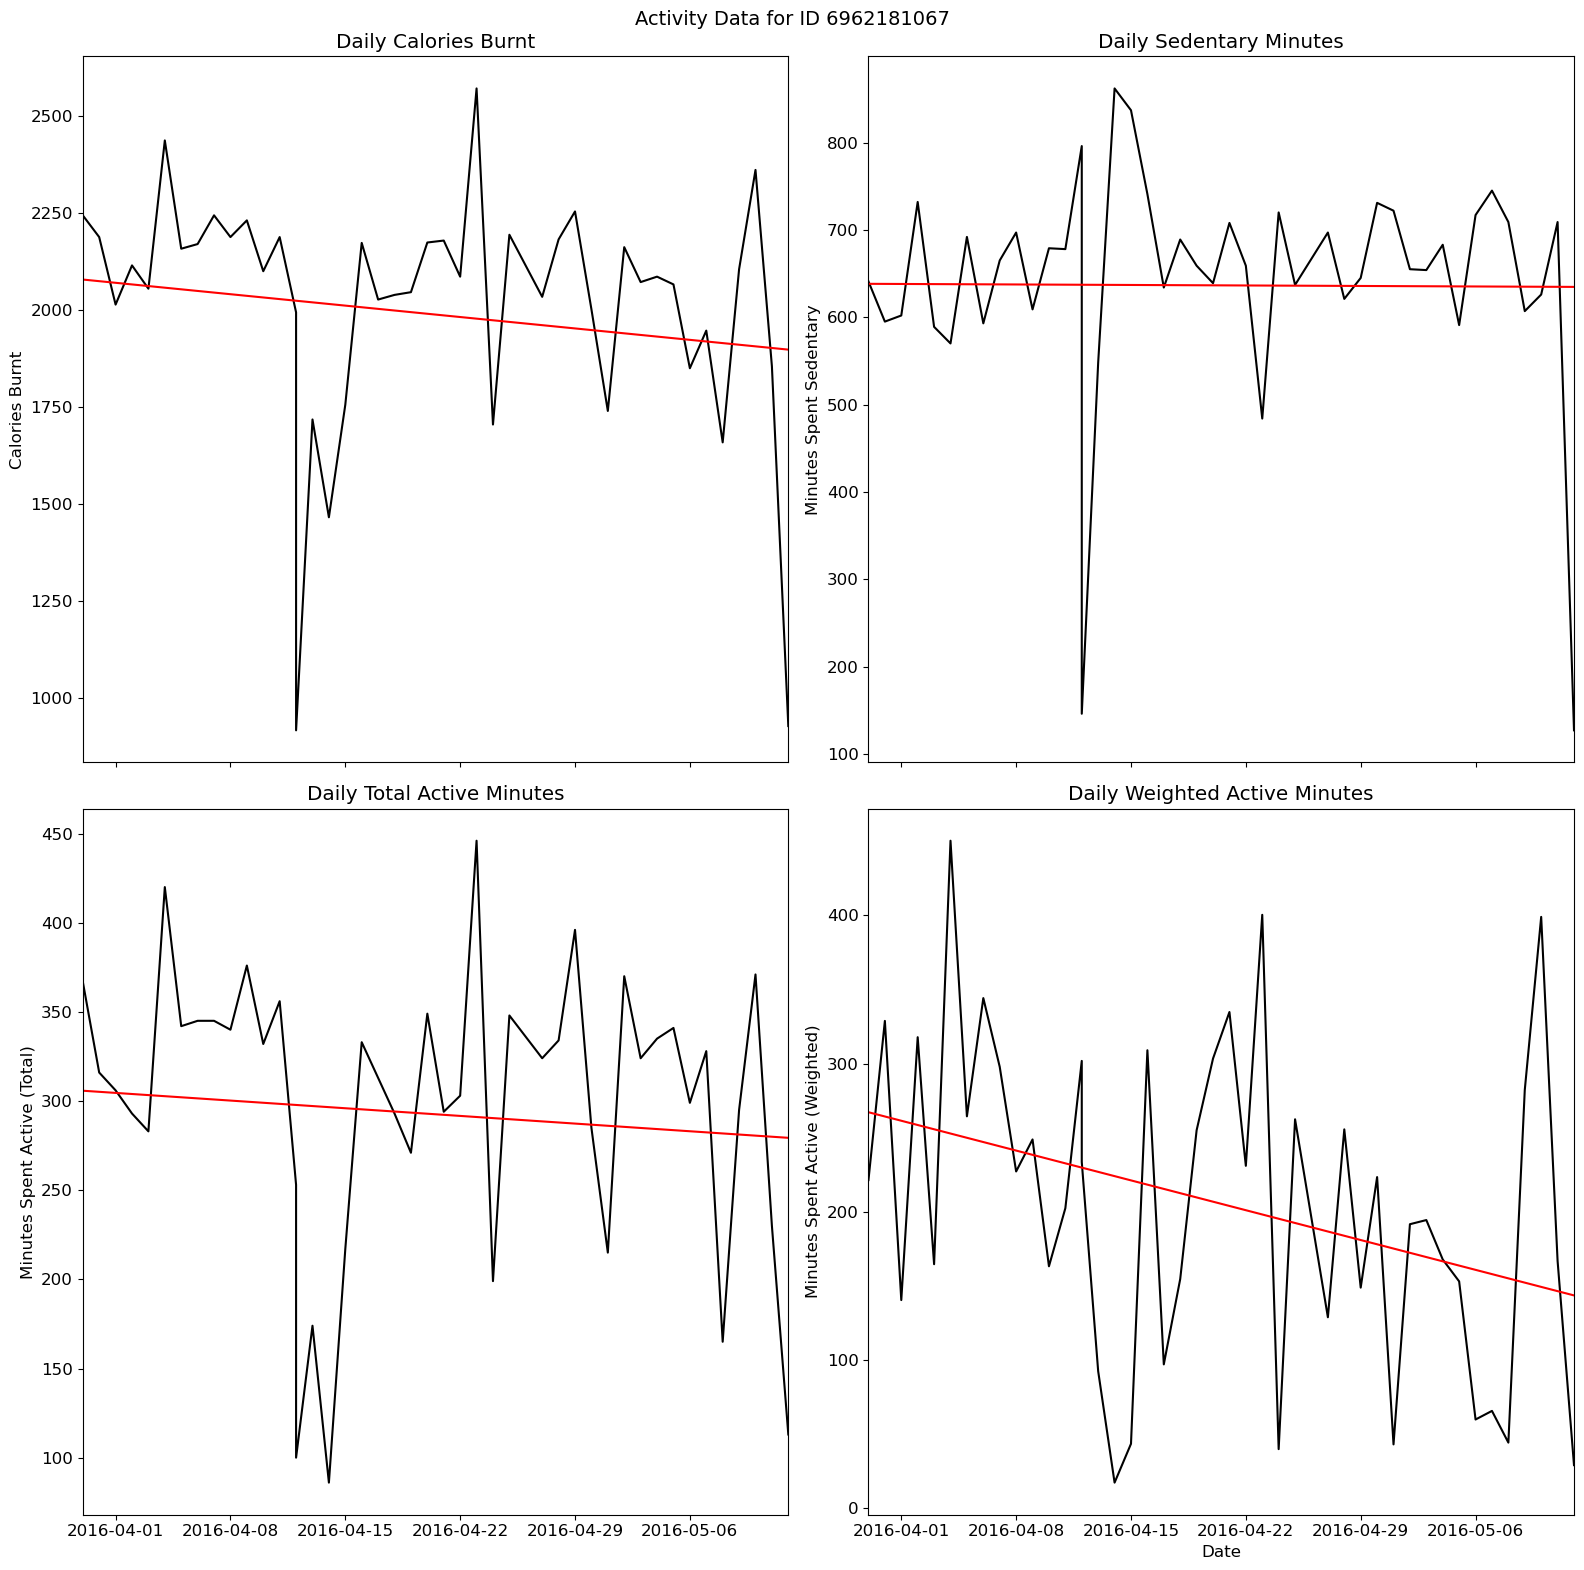

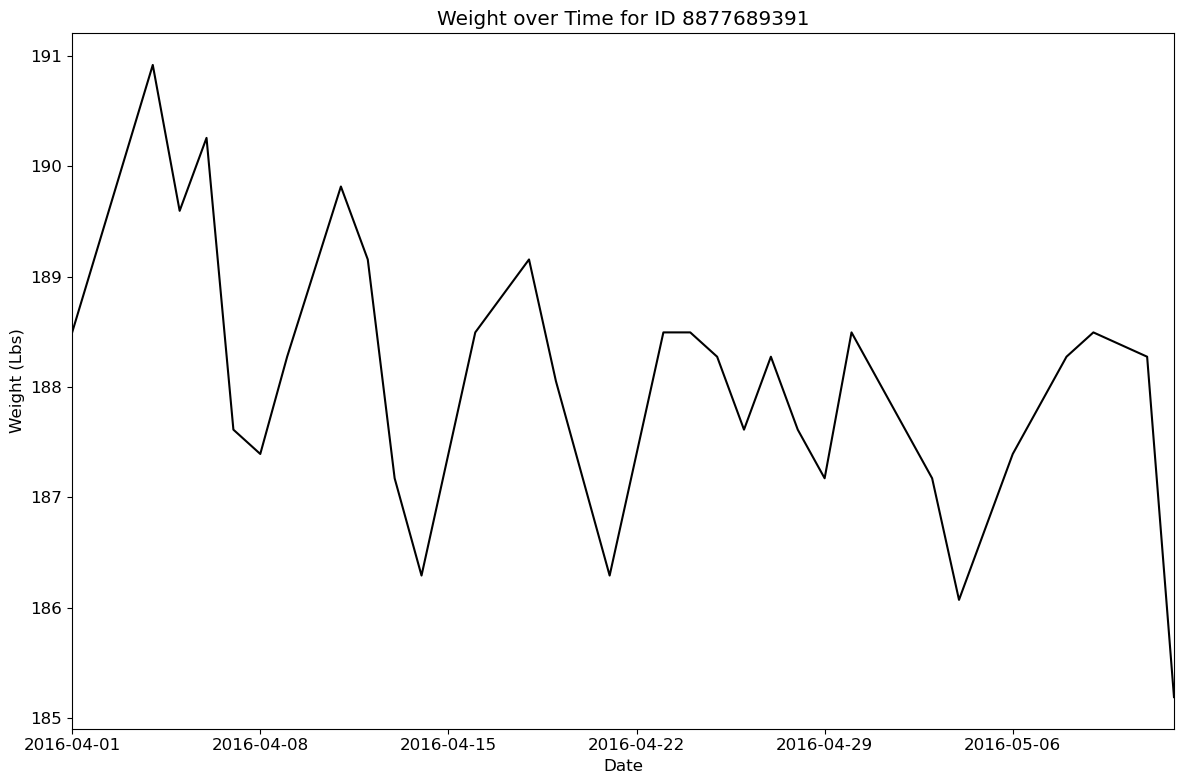

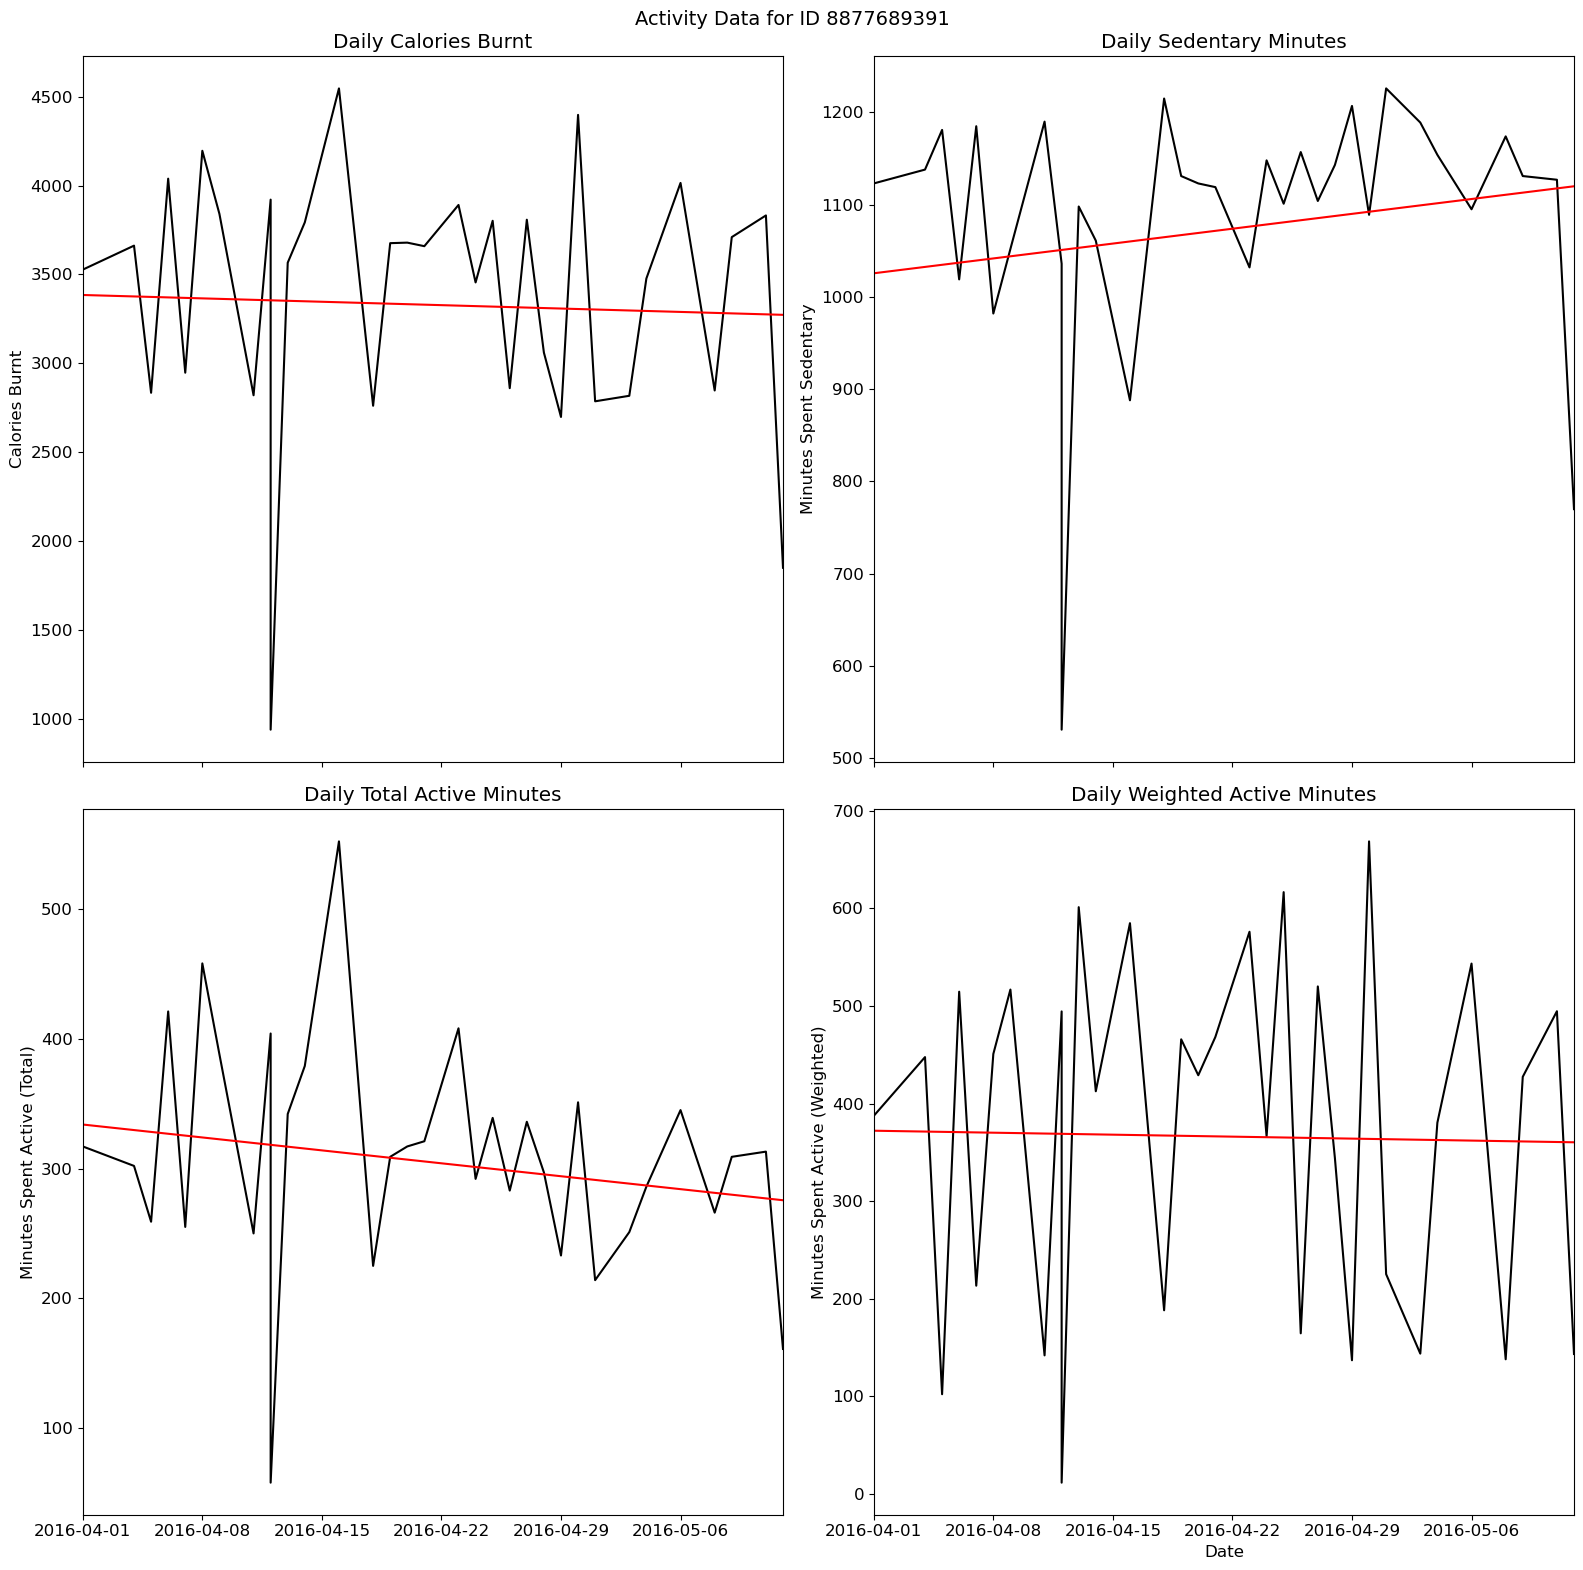

In [15]:
file_setup("generated_csvs/weight_change.csv","ID,Percent change\n")

plot_data(avg_users,fullData)
plot_data(freq_users,fullData)

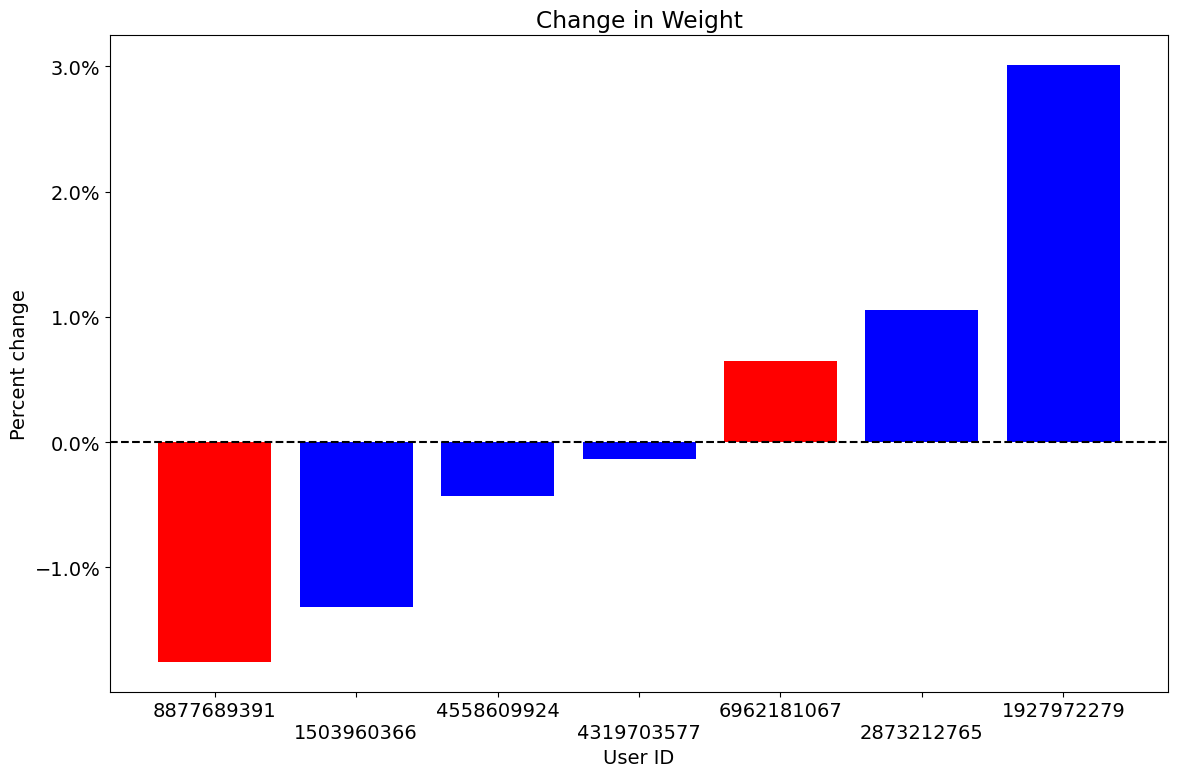

In [16]:
# Make bar plot to show percent change in weight over the two months for all users
warnings.filterwarnings("ignore")
make_bar_from_csv("generated_csvs/weight_change.csv","Change in Weight")
plt.tight_layout()
plt.savefig(f"images/weight_percent_change.png")
plt.show()